# Graph Analysis Script
This script will contain the following analyses:
* Spectral Graph Partitioning
* Node Degree Centrality Analysis
* Hierarchy Index Calculation
* Rich Club Coefficient Calculation
* Triangulative Potential Analysis

## Creating the required environment (skip if already done)

Running the following cell will create a file graphs.yml that can be used to setup a conda environment containing the required packages. If you already downloaded the file from my GitHub, skip the next cell and create the env directly from it.

In [ ]:
%%writefile graphs.yml
name: graphs
channels:
  - conda-forge
  - defaults
dependencies:
  - python=3.6
  - jupyter
  - imageio
  - imageio-ffmpeg
  - matplotlib
  - scikit-image
  - opencv
  - networkx
  - pandas
  - statsmodels

### Environment Creation
To create the environment, open the terminal, go to the directory where you stored the graphs.yml file (the directory of the notebook) and type
conda env create -f graphs.yml
After running this command you have to activate the environment (Linux/MacOS: conda activate graphs, Windows: activate graphs) and then reopen the notebook in that environment.

In [1]:
import os
import cv2
import json
import numpy as np
import re
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import glob
import scipy.cluster.vq as clusters
import scipy.sparse as sparse
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.preprocessing import normalize
from pandas.plotting import autocorrelation_plot as AC_plot 
from statsmodels.graphics import tsaplots
from statsmodels.tsa.stattools import acf
from skimage.filters import gaussian
from mpl_toolkits.mplot3d import Axes3D 
from matplotlib.colors import LinearSegmentedColormap


OG_DATA_PATH = './'
GIT_DATA_PATH = './Data Exploration/'
GIT_PROCESSED_DATA_PATH = './Results/'
GIT_GRAPH_PATH = './Results/Graphs/'
RESSOURCES_PATH = './Ressources/'

# Reset the Datapath since the data is not yet on Git, comment out if data is on Git 
DATA_PATH = '/Volumes/EXTENSION/Uni/Study Project/Data Exploration/'

PROCESSED_DATA_PATH = '/Volumes/EXTENSION/Uni/Study Project/Results/'
GRAPH_DATA_PATH = '/Volumes/EXTENSION/Uni/Study Project/Results/Graphs/'
# Getting the Folder without hidden files in ascending order 
DATA_FOLDER = sorted([f for f in os.listdir(DATA_PATH) if not f.startswith('.')], key=str.lower)
PROCESSED_DATA_FOLDER = sorted([f for f in os.listdir(PROCESSED_DATA_PATH) if not f.startswith('.')], key=str.lower)
GIT_PROCESSED_DATA_FOLDER = sorted([f for f in os.listdir(GIT_PROCESSED_DATA_PATH) if not f.startswith('.')], key=str.lower)
GIT_GRAPH_FOLDER = sorted([f for f in os.listdir(GIT_GRAPH_PATH) if not f.startswith('.')], key=str.lower)

#houselist 
house_file = RESSOURCES_PATH + 'building_collider_list.csv'
try:
    houselist = pd.read_csv(house_file)
except:
    print('HouseList could not be loaded!')
    
    

### Extracting all subject IDs from the data folder

In [2]:
subIDs = []
for sub in DATA_FOLDER:
    if sub[0].isdigit():
        subIDs.append(int(sub[0:4]))
    else:
        pass
subIDs = np.unique(subIDs)
print(subIDs)

[1005 1008 1010 1011 1013 1017 1018 1019 1021 1023 1079 1080]


In [2]:
# custom subID
subIDs = [1008]

### Loading the edgelists and creating the graphs 
* Also including the analyses

Subject 1005 started - 1/12
smallest Eigenvalue is 0
Graph is fully connected
Subject 1008 started - 2/12
smallest Eigenvalue is 0
Graph is fully connected
Subject 1010 started - 3/12
smallest Eigenvalue is 0
Graph is fully connected
Subject 1011 started - 4/12
smallest Eigenvalue is 0
Graph is fully connected
Subject 1013 started - 5/12
smallest Eigenvalue is 0
Graph is fully connected
Subject 1017 started - 6/12
smallest Eigenvalue is 0
Graph is fully connected
Subject 1018 started - 7/12
Subject 1018 has no data file!
Subject 1019 started - 8/12
Subject 1019 has no data file!
Subject 1021 started - 9/12
smallest Eigenvalue is 0
Graph is fully connected
Subject 1023 started - 10/12
smallest Eigenvalue is 0
Graph is fully connected
Subject 1079 started - 11/12
Subject 1079 has no data file!
Subject 1080 started - 12/12
Subject 1080 has no data file!
Done


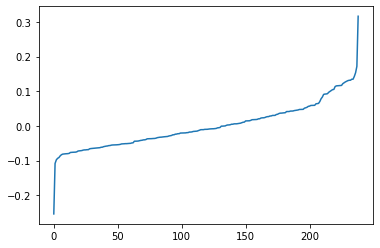

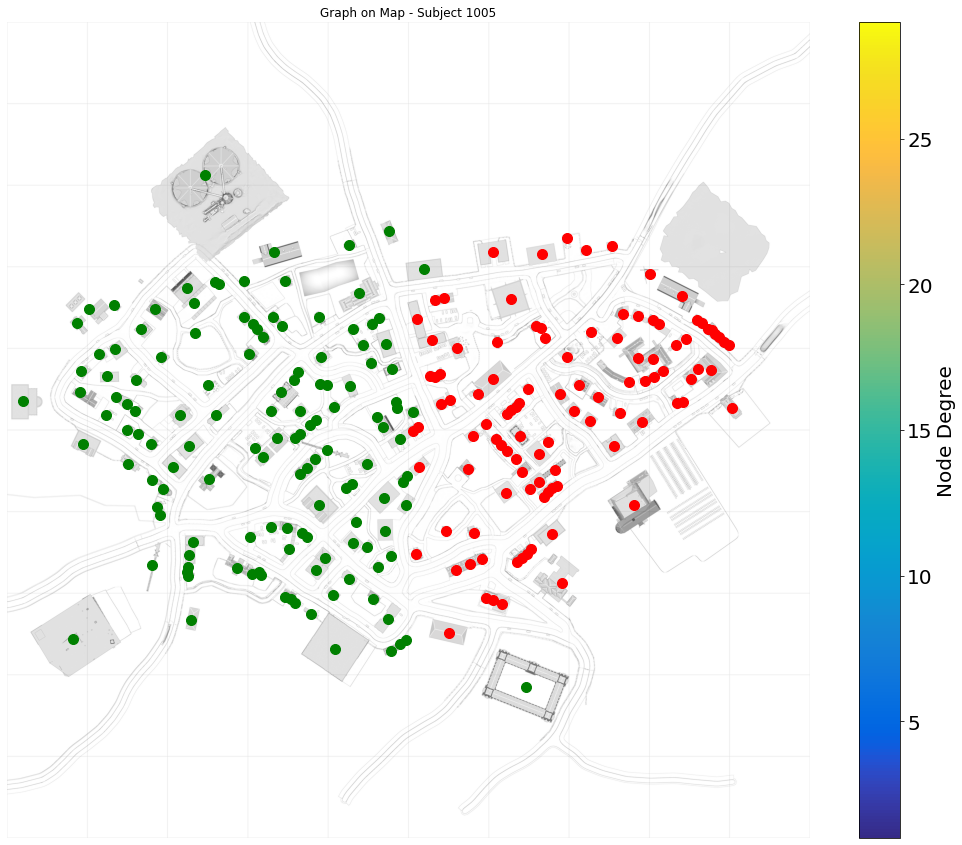

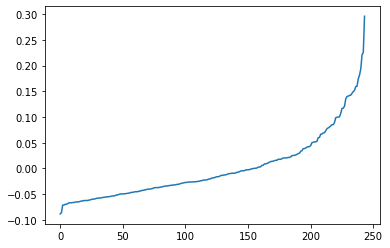

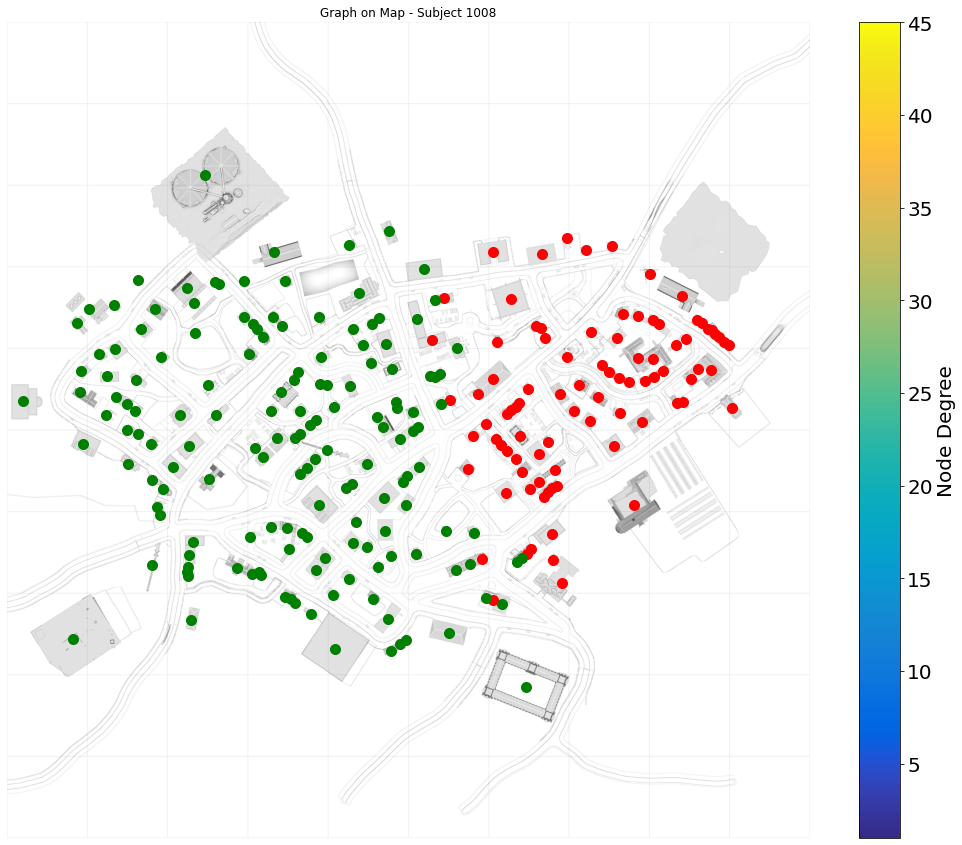

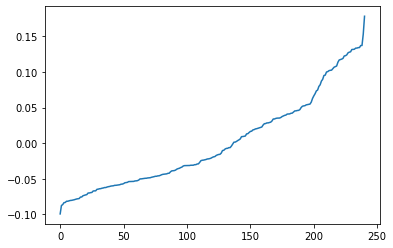

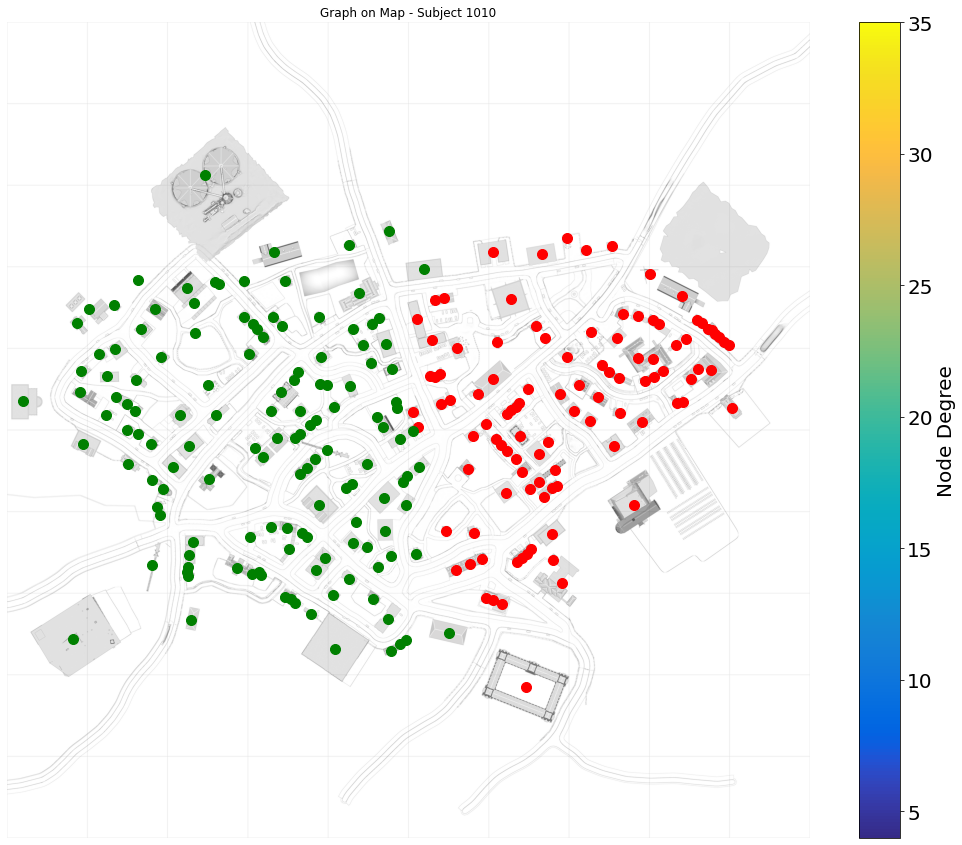

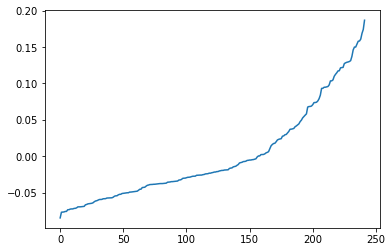

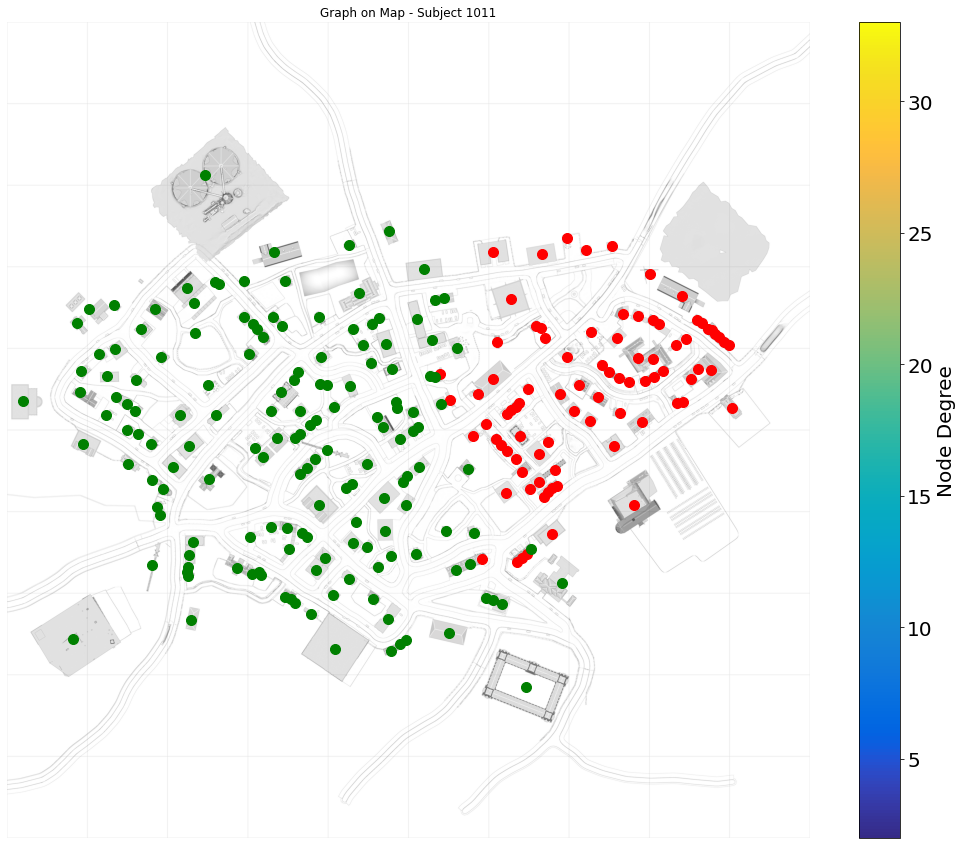

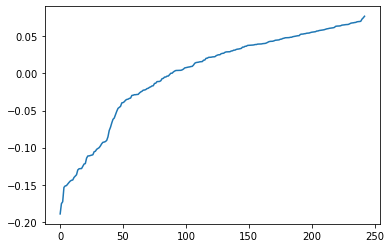

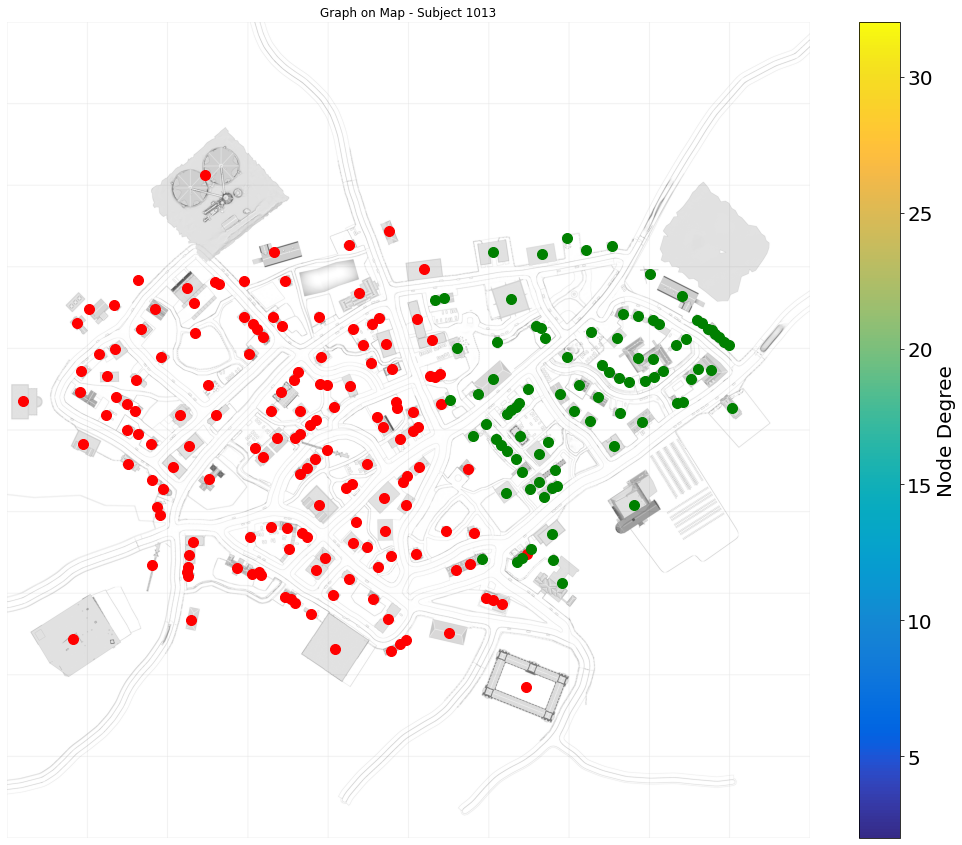

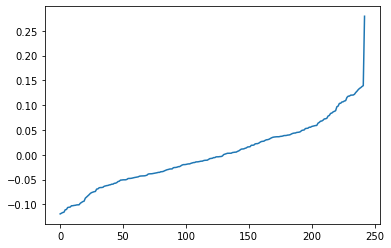

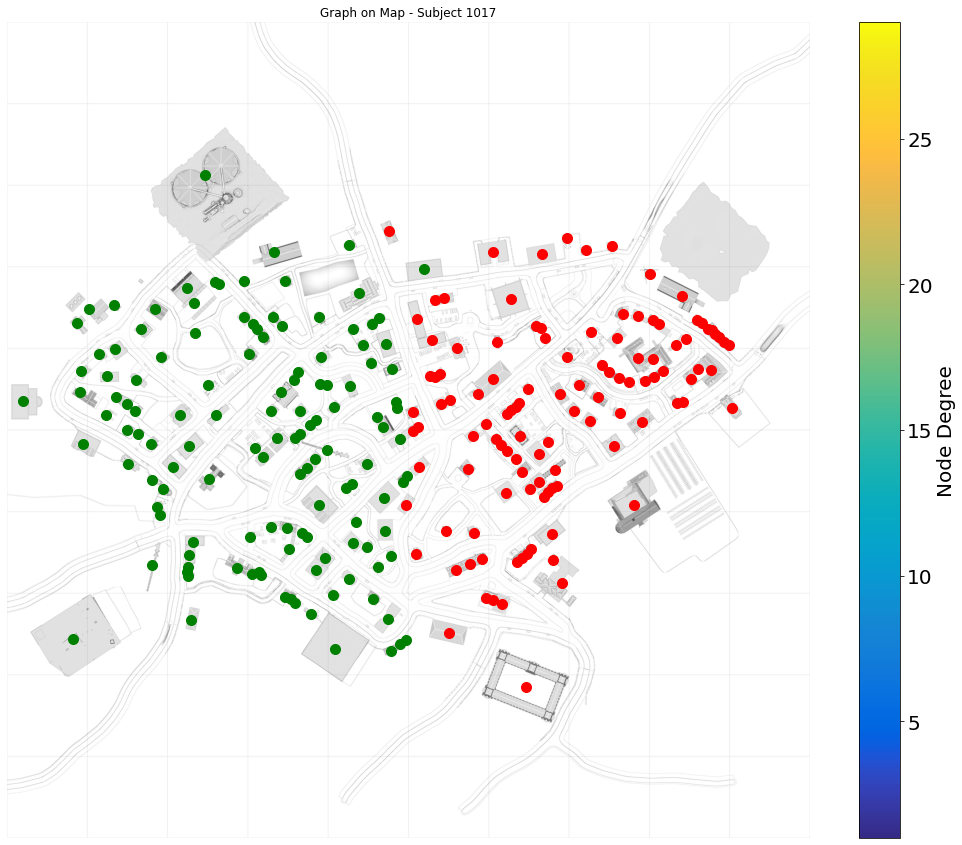

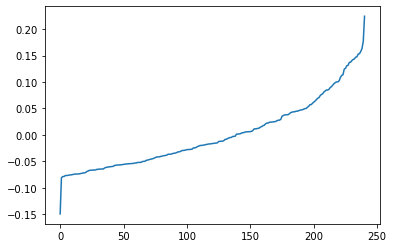

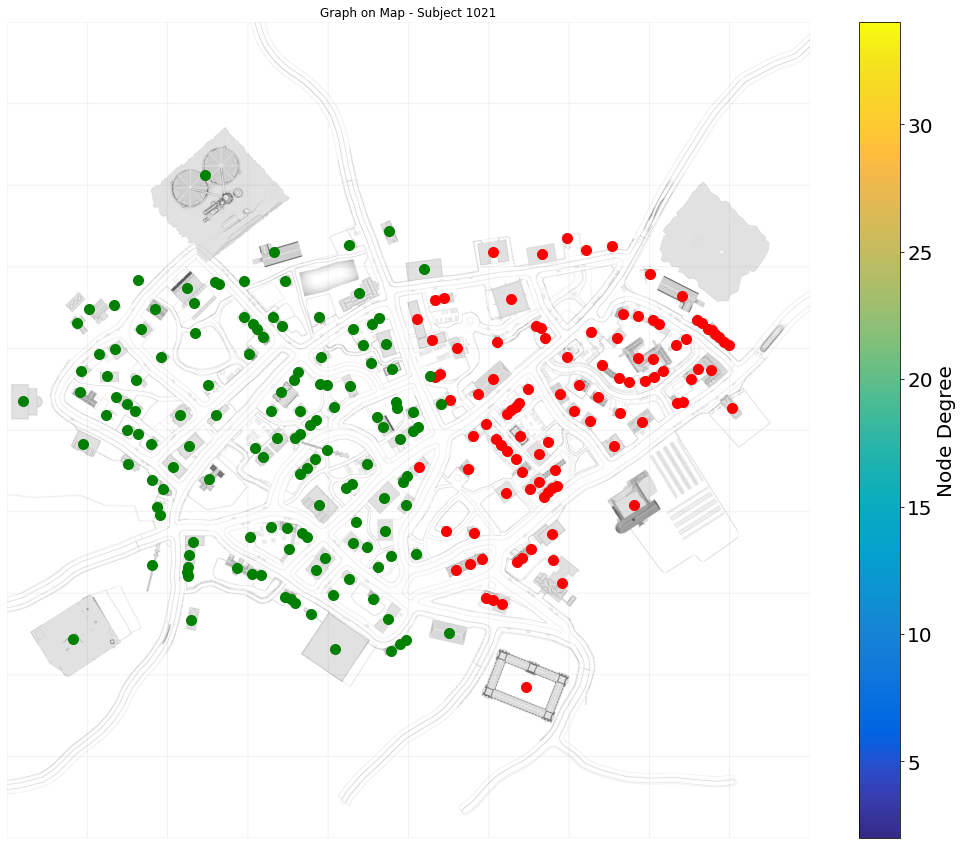

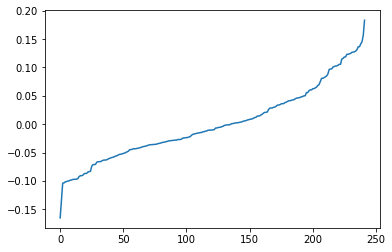

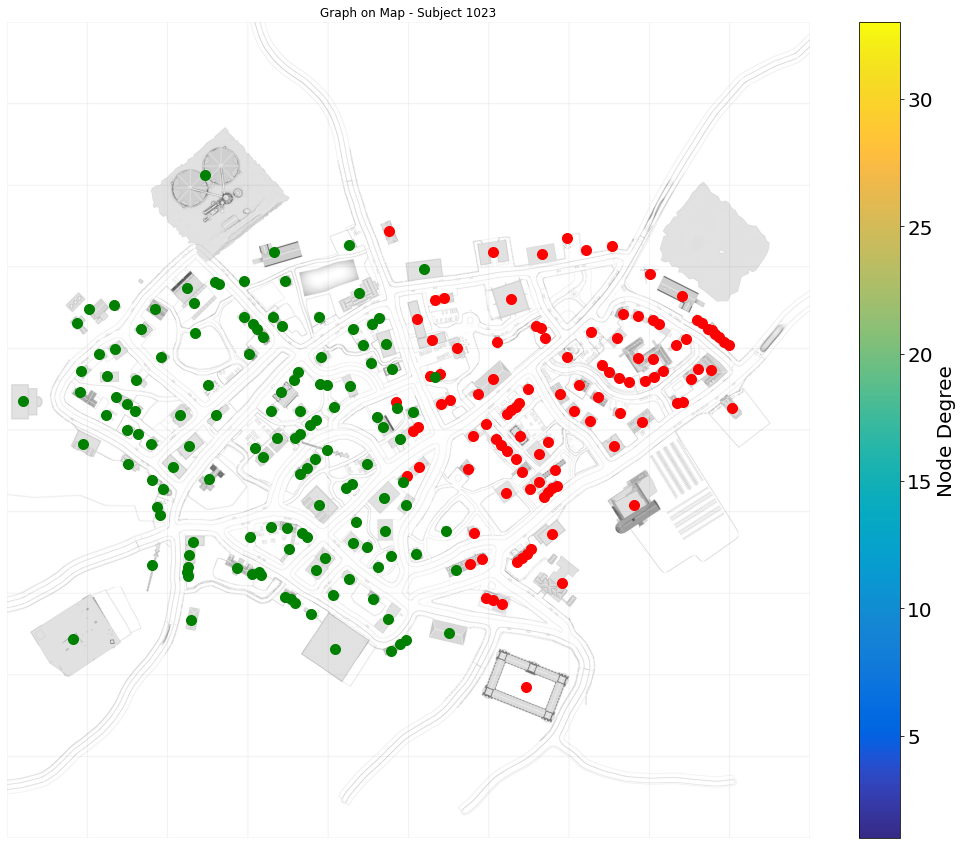

In [6]:
# --------- Preparation ---------
Plotting_bool = True # if you want to plot the graph
Graph_save_img_bool = False # if you want to save the graph as an image
plot_edges_bool = False # if you want to plot the graph's edges
save_centrality = False # if you want to save the centrality dataframe (node degree) as csv 

calculate_Partitioning = True # if you want to calculate the graph partitioning
calculate_ND = False # if you want to calculate the node degree statistics
calculate_Hierarchy = False  # if you want to calculate the hierarchy index 
calculate_RC = False  # if you want to calculate the rich club coefficient
calculate_triang = False  # if you want to calculate the triangulation

subcount = 0 # count subjects

PartitioningDoc = pd.DataFrame()

# implement parula color map scheme from matlab 
cm_data = [[0.2081, 0.1663, 0.5292], [0.2116238095, 0.1897809524, 0.5776761905], 
 [0.212252381, 0.2137714286, 0.6269714286], [0.2081, 0.2386, 0.6770857143], 
 [0.1959047619, 0.2644571429, 0.7279], [0.1707285714, 0.2919380952, 
  0.779247619], [0.1252714286, 0.3242428571, 0.8302714286], 
 [0.0591333333, 0.3598333333, 0.8683333333], [0.0116952381, 0.3875095238, 
  0.8819571429], [0.0059571429, 0.4086142857, 0.8828428571], 
 [0.0165142857, 0.4266, 0.8786333333], [0.032852381, 0.4430428571, 
  0.8719571429], [0.0498142857, 0.4585714286, 0.8640571429], 
 [0.0629333333, 0.4736904762, 0.8554380952], [0.0722666667, 0.4886666667, 
  0.8467], [0.0779428571, 0.5039857143, 0.8383714286], 
 [0.079347619, 0.5200238095, 0.8311809524], [0.0749428571, 0.5375428571, 
  0.8262714286], [0.0640571429, 0.5569857143, 0.8239571429], 
 [0.0487714286, 0.5772238095, 0.8228285714], [0.0343428571, 0.5965809524, 
  0.819852381], [0.0265, 0.6137, 0.8135], [0.0238904762, 0.6286619048, 
  0.8037619048], [0.0230904762, 0.6417857143, 0.7912666667], 
 [0.0227714286, 0.6534857143, 0.7767571429], [0.0266619048, 0.6641952381, 
  0.7607190476], [0.0383714286, 0.6742714286, 0.743552381], 
 [0.0589714286, 0.6837571429, 0.7253857143], 
 [0.0843, 0.6928333333, 0.7061666667], [0.1132952381, 0.7015, 0.6858571429], 
 [0.1452714286, 0.7097571429, 0.6646285714], [0.1801333333, 0.7176571429, 
  0.6424333333], [0.2178285714, 0.7250428571, 0.6192619048], 
 [0.2586428571, 0.7317142857, 0.5954285714], [0.3021714286, 0.7376047619, 
  0.5711857143], [0.3481666667, 0.7424333333, 0.5472666667], 
 [0.3952571429, 0.7459, 0.5244428571], [0.4420095238, 0.7480809524, 
  0.5033142857], [0.4871238095, 0.7490619048, 0.4839761905], 
 [0.5300285714, 0.7491142857, 0.4661142857], [0.5708571429, 0.7485190476, 
  0.4493904762], [0.609852381, 0.7473142857, 0.4336857143], 
 [0.6473, 0.7456, 0.4188], [0.6834190476, 0.7434761905, 0.4044333333], 
 [0.7184095238, 0.7411333333, 0.3904761905], 
 [0.7524857143, 0.7384, 0.3768142857], [0.7858428571, 0.7355666667, 
  0.3632714286], [0.8185047619, 0.7327333333, 0.3497904762], 
 [0.8506571429, 0.7299, 0.3360285714], [0.8824333333, 0.7274333333, 0.3217], 
 [0.9139333333, 0.7257857143, 0.3062761905], [0.9449571429, 0.7261142857, 
  0.2886428571], [0.9738952381, 0.7313952381, 0.266647619], 
 [0.9937714286, 0.7454571429, 0.240347619], [0.9990428571, 0.7653142857, 
  0.2164142857], [0.9955333333, 0.7860571429, 0.196652381], 
 [0.988, 0.8066, 0.1793666667], [0.9788571429, 0.8271428571, 0.1633142857], 
 [0.9697, 0.8481380952, 0.147452381], [0.9625857143, 0.8705142857, 0.1309], 
 [0.9588714286, 0.8949, 0.1132428571], [0.9598238095, 0.9218333333, 
  0.0948380952], [0.9661, 0.9514428571, 0.0755333333], 
 [0.9763, 0.9831, 0.0538]]

parula_map = LinearSegmentedColormap.from_list('parula', cm_data)

# load the city map image
white_bg_img = cv2.imread("./ressources/map_white.png")

# open the JSON file as dictionary
with open(GIT_GRAPH_PATH + 'centrality_df.csv') as f:
    try:
        centrality_df = pd.read_csv(f)
    except:
            print("\tCould not load centrality_df!")




# --------- MAIN PART ---------
# load the files 
for subject in subIDs:
    subcount +=1
    print('Subject ' + str(subject) + ' started - ' + str(subcount) + '/' + str(len(subIDs)))
    
    # get the data files according to the subject
    subject_folder = sorted([f for f in GIT_GRAPH_FOLDER 
                             if f.startswith(str(subject)+'_edgelist')], key=str.lower)

    if len(subject_folder) != 0:
        
        # open the JSON file as dictionary
        with open(GIT_GRAPH_PATH + subject_folder[0]) as f:
            try:
                edge_list = pd.read_csv(f)
            except:
                    print("\tCould not load subject " + str(subject) + " edgelist!")

    else:
        print('Subject ' + str(subject) + ' has no data file!')
        continue 



    # --------- GRAPH CREATION ---------

    # create graph from edgelist
    G = nx.Graph()
    G = nx.from_pandas_edgelist(edge_list, 'Edge1', 'Edge2')


    # Setting the node coordinates of each node of the graph


    # node list
    nodelist = list(G.nodes)
    nodearray = np.array(G.nodes)

    # coord dict
    node_pos = {}

    for node in nodelist:
        # assign node coordinates
        x = houselist['transformed_collidercenter_x'][houselist.target_collider_name==node].values[0]
        y = houselist['transformed_collidercenter_y'][houselist.target_collider_name==node].values[0]
        node_pos[node] = (x,y) 

    # set the graph's node coordinates attribute
    nx.set_node_attributes(G, node_pos, 'coord')


    # --------- ANALYSIS ---------

    # --------- PARTITIONING ---------
    if calculate_Partitioning == True:     
        # ---- Step 1 ----
        
        # get laplacian matrix and its eigenvalues + eigenvectors
        laplacian_matrix = nx.laplacian_matrix(G)
        laplacian_matrix = sparse.csr_matrix.toarray(laplacian_matrix)
        # Eigenvalues and vectors
        Eigenvalue, Eigenvector = np.linalg.eig(laplacian_matrix)
        # sort Eigenvalues in ascending order and use index to sort eigenvectors
        index_array = np.argsort(Eigenvalue)
    
        # check if smallest eigenvalue is 0 (or close to 0)
        if Eigenvalue[index_array][0] < 1e-10:
            print('smallest Eigenvalue is 0')
            # check if second smallest eigenvalue is larger 0 (this means the graph is fully connected)
            if Eigenvalue[index_array][1] > 1e-10:
                print('Graph is fully connected')
                
                # create a dataframe and assign both the eigenvector sorted
                house_eig_df = pd.DataFrame()
                house_eig_df['House'] = nodearray
                house_eig_df['Eigenvector'] = Eigenvector[:,index_array[1]]
                
                
                eig_pos = house_eig_df[house_eig_df.Eigenvector > 0]
                eig_neg = house_eig_df[house_eig_df.Eigenvector < 0]
                
                # create the subgraphs
                posG = G.subgraph(eig_pos.House)
                negG = G.subgraph(eig_neg.House)
                
                totalEdges = G.number_of_edges()
                C1_Edges = posG.number_of_edges() 
                C2_Edges = negG.number_of_edges()
                combinedEdges = C1_Edges + C2_Edges
                Cut_Edges = totalEdges - combinedEdges
                total_nodes = G.number_of_nodes()
                C1_nodes = posG.number_of_nodes()
                C2_nodes = negG.number_of_nodes()
                
                
                
                
                transition_df = pd.DataFrame()
                transition_df.loc[0, 'Subject'] = subject
                transition_df.loc[0, 'Complete Edges'] = totalEdges
                transition_df.loc[0, 'C1 Edges'] = C1_Edges
                transition_df.loc[0, 'C2 Edges'] = C2_Edges
                transition_df.loc[0, 'Cut Edges'] = Cut_Edges
                transition_df.loc[0, 'Total Nodes'] = total_nodes
                transition_df.loc[0, 'C1 Nodes'] = C1_nodes
                transition_df.loc[0, 'C2 Nodes'] = C2_nodes
                transition_df.loc[0, 'Complete Degree'] = (totalEdges*2)/total_nodes
                transition_df.loc[0, 'C1 Degree'] = C1_Edges/C1_nodes*2
                transition_df.loc[0, 'C2 Degree'] = C2_Edges/C2_nodes*2
                
                #transition_df['Cut Proportion'] = 
                
                PartitioningDoc = PartitioningDoc.append(transition_df)
                
                plt.figure()
                plt.plot(np.sort(Eigenvector[:,index_array[1]]))
          
            else:
                print('Graph is not fully connected')
    
    
    # --------- NODE DEGREE ---------
    if calculate_ND == True: 
    
        # create degree list of the graph 
        sub_degree = dict(list(G.degree))
        # add the subject ID to the dictionary
        sub_degree.update({'Subject': str(subject)})  
        # append the centrality df by the subjects degree list
        centrality_df = centrality_df.append(sub_degree, ignore_index=True)
        #centrality_df['betweenness'] = list(nx.betweenness_centrality(G))


        mean_degree = np.nanmean(pd.to_numeric(centrality_df[centrality_df.Subject==str(subject)].values[0])[1:])
        std_degree = np.nanstd(pd.to_numeric(centrality_df[centrality_df.Subject==str(subject)].values[0])[1:])
        max_degree = max(pd.to_numeric(centrality_df[centrality_df.Subject==str(subject)].values[0])[1:])


    
    # --------- HIERARCHY INDEX ---------
    if calculate_Hierarchy == True: 
        pass
    
    
    # --------- RICH CLUB COEFFICIENT ---------
    if calculate_RC == True:     
        pass
    
    
    # --------- TRIANGULATION ---------
    if calculate_triang == True: 
        pass
    
    

    
    # --------- PLOTTING ---------    

    if Plotting_bool == True:

        # plot the map
        fig = plt.figure(figsize=(20,15))
        ax = plt.subplot2grid((10, 10), (0, 0), colspan=9,rowspan=10)
        plt.title("Graph on Map - Subject " + str(subject))
        plt.xlim(0, 4096)
        plt.ylim(0, 4096)
        ax.set_frame_on(False)
        plt.axis('off')
        plt.imshow(white_bg_img,aspect=ax.get_aspect(),
                 extent= ax.get_xlim() + ax.get_ylim(),
                 zorder=1, alpha=0.8)

        # Draw the graph 
        vmin = np.min(np.array(centrality_df[centrality_df['Subject'] == str(subject)])[0][1:-2])
        vmax = np.max(np.array(centrality_df[centrality_df['Subject'] == str(subject)])[0][1:-2])
        
        
        # plotting the clusters
        # positive cluster
        nx.draw_networkx_nodes(posG, node_color = 'r', pos=node_pos, node_size=100)
        # negative cluster
        nx.draw_networkx_nodes(negG, node_color = 'g', pos=node_pos, node_size=100)
        
        
        
        
        if plot_edges_bool == True:
            nx.draw_networkx_edges(G, 
                                   node_pos, 
                                   edge_color='k', 
                                   alpha=0.5, 
                                   width=1,
                                   style='dashed')


        # subgraph for highlighting single nodes
        #building = centrality_df.sort_values('degree', ascending=False)[:10].node.values
        #nx.draw_networkx(G.subgraph(building), node_color = 'r', pos=node_pos, node_size=400)


        sm = plt.cm.ScalarMappable(cmap=parula_map, norm=plt.Normalize(vmin=vmin, vmax=vmax))
        sm.set_array([])
        cbar = plt.colorbar(sm)
        cbar.ax.tick_params(labelsize=20)
        cbar.set_label('Node Degree', size=20)

    else:
        Graph_save_img_bool = False


    # --------- SAVING ---------


    # save the graph as png 
    if Graph_save_img_bool == True:
        # saving the subject info dataframe
        try:
            plt.savefig(GIT_GRAPH_PATH + str(subject) + "_Graph.png", format="PNG")

            print("\tGraph PNG saved")
        except:
            print("\tCould not save subject " + str(subject) + " Graph as PNG!")

            
            
# --------- SUBJECT INDEPENDENT SAVINGS ---------   
            
# Add the mean over both axes to the centrality df and save it 


house_mean_dict = dict(centrality_df.loc[:,centrality_df.columns[1:]].mean(axis=0))
house_mean_dict.update({'Subject': 'Mean'})  
                 
house_std_dict = dict(centrality_df.loc[:,centrality_df.columns[1:]].std(axis=0))
house_std_dict.update({'Subject': 'STD'})  
                
centrality_df = centrality_df.append(house_mean_dict, ignore_index=True)
centrality_df = centrality_df.append(house_std_dict, ignore_index=True)

subject_mean = centrality_df.loc[:,centrality_df.columns[1:]].mean(axis=1)
subject_std = centrality_df.loc[:,centrality_df.columns[1:]].std(axis=1)
                 
centrality_df['Mean'] = subject_mean
centrality_df['STD'] = subject_std
    
        
if save_centrality == True: 
    # saving the subject info dataframe
    try:
        centrality_df.to_csv(GIT_GRAPH_PATH
                        + "_degree_table.csv", 
                        index=False)

        print("\tCentrality Dataframe saved")
    except:
        print("\tCould not save centrality dataframe!")



    
print('Done')
    

Laplacian Matrix of one Subject 
2 0 -1 
0 1 0
-1 -1 2 

Eigenvalue spectrum of the matrix 242 eigenvalues of laplacian matrix

Sort the eigenvalues in ascending order, 2nd smallest eigenvalue and compute the eigenvector  

242, 242 --> filter out the actual eigenvector 

In [23]:
house_eig_df


,House,Eigenvector
0,Building_161,0.001434
1,Building_145,0.042228
2,TaskBuilding_5,-0.014271
3,Building_151,-0.009396
4,TaskBuilding_27,0.028503
...,...,...
237,Building_191,0.001961
238,Building_223,-0.038648
239,Garage_86,-0.004152
240,Building_78,0.009082


In [7]:
PartitioningDoc

,Subject,Complete Edges,C1 Edges,C2 Edges,Cut Edges,Total Nodes,C1 Nodes,C2 Nodes,Complete Degree,C1 Degree,C2 Degree
0,1005.0,1476.0,532.0,799.0,145.0,239.0,105.0,134.0,12.351464,10.133333,11.925373
0,1008.0,1925.0,527.0,1225.0,173.0,244.0,89.0,155.0,15.778689,11.842697,15.806452
0,1010.0,1718.0,599.0,991.0,128.0,241.0,104.0,137.0,14.257261,11.519231,14.467153
0,1011.0,1622.0,396.0,1114.0,112.0,242.0,85.0,157.0,13.404959,9.317647,14.191083
0,1013.0,1607.0,1036.0,460.0,111.0,243.0,155.0,88.0,13.226337,13.367742,10.454545
0,1017.0,1555.0,645.0,761.0,149.0,243.0,113.0,130.0,12.798354,11.415929,11.707692
0,1021.0,1479.0,470.0,881.0,128.0,241.0,102.0,139.0,12.273859,9.215686,12.676259
0,1023.0,1894.0,714.0,981.0,199.0,242.0,107.0,135.0,15.652893,13.345794,14.533333


In [34]:
laplacian_matrix = nx.laplacian_matrix(G)
laplacian_matrix = sparse.csr_matrix.toarray(laplacian_matrix)

In [35]:
laplacian_matrix = nx.laplacian_matrix(G)
laplacian_matrix = sparse.csr_matrix.toarray(laplacian_matrix)
Eigenvalue, Eigenvector = np.linalg.eig(laplacian_matrix)

index_array = np.argsort(Eigenvalue)
eig_vec_index = np.argsort(Eigenvector[index_array][1])

In [51]:
index_array = np.argsort(w)

In [68]:
eig_veg_index = np.argsort(v[index_array][1])

In [76]:
nodes = np.array(G.nodes)

nodes[eig_veg_index]

array(['Building_118', 'Building_57', 'TaskBuilding_41', 'Building_119',
       'Building_147', 'Building_72', 'Building_202', 'Building_141',
       'Building_179', 'Building_191', 'Building_106', 'Building_168',
       'TaskBuilding_54', 'TaskBuilding_47', 'Building_80',
       'Building_113', 'Building_163', 'Building_151', 'Building_66',
       'Building_65', 'Building_221', 'Building_186', 'Building_200',
       'Building_59', 'Building_138', 'Garage_86', 'Building_187',
       'Building_205', 'House_49', 'TaskBuilding_32', 'Building_183',
       'Building_125', 'Building_92', 'Building_108', 'Building_161',
       'Garage_235', 'Building_74', 'Building_134', 'Building_62',
       'Building_96', 'Building_155', 'Building_153', 'Building_180',
       'Building_160', 'Building_171', 'TaskBuilding_33', 'Building_135',
       'TaskBuilding_48', 'TaskBuilding_29', 'TaskBuilding_23',
       'Building_220', 'Building_149', 'Building_114', 'TaskBuilding_4',
       'Building_131', 'Buildin